In [1]:
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import normalize

In [45]:
def create_globular_clusters(n_clusters, dim, samples_per_cluster=100, cluster_std = 1, seed=None, centers = None):
    """
    Arguments:
        n_clusters: Int
        dim: Int
        samples_per_cluster: Int or array. 
            If array then len(array) == n_clusters must be true
        seed: Int
        cluster_std: int or array.
            If array then len(array) == n_clusters must be true
        centers: int or array.
            If array then len(array) == n_clusters must be true
    Output:
        X: array with shape (sum(samples_per_cluster), dim)
        y: array with shape (sum(samples_per_cluster),)
        cluster_colors: array with shape (sum(samples_per_cluster),)
    """
    
    colors = ['skyblue', 'turquoise', 'teal', 'slateblue', 'navy', 'lightsteelblue']
    
    X, y = make_blobs(n_samples=samples_per_cluster, 
                      centers=centers, 
                      n_features=dim, 
                      random_state=seed,
                      cluster_std = cluster_std)
    
    cluster_colors = [colors[c_id % len (colors)] for c_id in y]
    
    return X, y, cluster_colors

In [46]:
def post_process_1d_clusters(X, y):
    
    X_datasets = []
    cluster_ids = list(set(y))
    
    for c_idx in cluster_ids:
        cluster = []
        for idx in range(len(X)):
            if y[idx] == c_idx:
                cluster += X[idx].tolist()
        X_datasets.append(cluster)
    
    colors = ['skyblue', 'turquoise', 'teal', 'slateblue', 'navy', 'lightsteelblue']
    
    cluster_colors = [colors[c_id % len(colors)] for c_id in range(len(cluster_ids))]
    
    return X_datasets, cluster_colors

In [47]:
n_clusters = 3
dim = 1
samples_per_cluster = [300, 300, 440]
cluster_std = [1, 0.5 , 2]

X, y, cc = create_globular_clusters(n_clusters, dim, samples_per_cluster, cluster_std)
X1d, cc = post_process_1d_clusters(X, y)

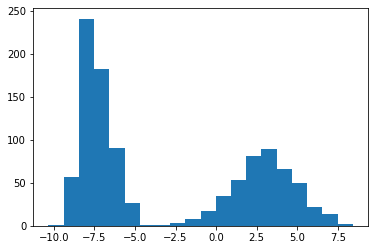

In [48]:
#plt.hist(X1d, bins = 80, color=cc)
plt.hist(X, bins = 20)
plt.show()

In [49]:
n_clusters = 3
dim = 2
samples_per_cluster = [30, 30, 50]
cluster_std = [1, 0.5 , 2]

X, y, cc = create_globular_clusters(n_clusters, dim, samples_per_cluster, cluster_std)

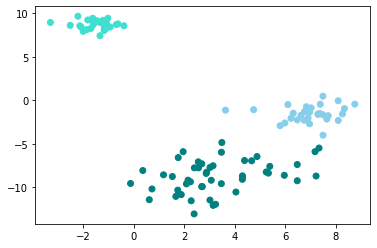

In [50]:
plt.scatter(X[:,0], X[:,1], c = cc)
plt.show()

__Implementation of 1D EM GMM, using verified data and initialization__

In [53]:
np.random.seed(0)
X = np.linspace(-5,5,num=20)
X0 = X*np.random.rand(len(X))+15 # Create data cluster 1
X1 = X*np.random.rand(len(X))-15 # Create data cluster 2
X2 = X*np.random.rand(len(X)) # Create data cluster 3
X = np.stack((X0,X1,X2)).flatten() # Combine the clusters to get the random 

In [54]:
def plot_gaussians_vs_data(x, gaussians, mus, sigmas):
    
    _max = 20 #np.amax(x) + 20
    _min = -20 #np.amin(x) - 20
    
    #k = 0
    
    plt.hist(x, bins = 30, density = True)
    
    for k in range(len(gaussians)):
        gaussian = gaussians[k]
        mu = mus[k]
        sigma = sigmas[k]
        
        #uni-variate
        steps = int((_max - _min) / 0.01)
        x = np.linspace(_min, _max, steps, endpoint=False)
        coords = gaussian.pdf(x)
        plt.plot(x, coords)
        plt.vlines(ymin = 0, ymax = (max(coords)), x=mu,color='black', ls='--', alpha = 0.2)
    plt.show()
    
    
        #plt.xlabel("Skill")
        #plt.legend(['Player 1', 'Player 2'])
        #plt.savefig(f'gaussian_{image_idx}.png')
        #print(f"mean: {mean}")
        #print(f"var: {gaussian['cov']}")

In [55]:
def EM_GMM_1D(X, n_clusters=3, epsilon=0.001, dim = 1, seed = 0, max_iter = 100):
    
    np.random.seed(seed)
    
    # --- Step 1: ---
    
    # Fix 2 <= c <= len(X) and fix any epsilon (stop condition).

    c = n_clusters
    eps = epsilon
    max_X = np.amax(X)
    min_X = np.amin(X)
    n = X.shape[0]
    z_hat_ki = np.zeros((n, c))
    
    #alpha = np.random.dirichlet(np.ones(n_clusters))
    #mus = np.random.uniform(min_X, max_X, n_clusters)
    #sigmas = np.random.uniform(0, max_X/2, n_clusters)
    
    #tutorial init
    alpha = [1/3,1/3,1/3]
    mus = [-8,8,5]
    sigmas = [5,3,1]
    
    try:
        X.shape[1]
    except:
        X = X.reshape(n, 1)
    
    # Give initials z_hat = (z_hat_1, z_hat_2, ... z_hat_c)
    
    z_hat = [norm(loc=mus[k], scale = sigmas[k]) for k in range(c)]
    
    for s in range(max_iter + 1):  
    
    # --- Step 2: ---

        #equation 4
        for k, z, p in zip(range(c), z_hat, alpha):
                    z_hat_ki[:,k] = (p * z.pdf(X)).reshape(n,)

        #z_hat_ki = normalize(z_hat_ki, axis=1, norm='l1'), does do the same thing?
        
        for i in range(n):
                z_hat_ki[i] = z_hat_ki[i]/(np.sum(alpha)*np.sum(z_hat_ki ,axis=1)[i])
        
        #equation 6
        alpha = np.sum(z_hat_ki, axis = 0)/n
        
        #equation 8
        mus = np.sum(z_hat_ki * X.reshape(n,1), axis = 0) / np.sum(z_hat_ki, axis = 0)
        
        # --- Step 3: ---

        #equation 9
        centered_X = X - mus
        sigma = np.zeros(c)

        for k in range(c):
            c_X = X - mus[k]
            sigma[k] = np.dot((z_hat_ki[:,k].reshape(n,1)*(c_X.reshape(n,1))).T,
                                      (c_X.reshape(n,1))) / np.sum(z_hat_ki[:,k])
        
        # --- Step 4: ---

        #update parameters

        z_hat_s_minus_1 = z_hat
        z_hat = [norm(loc=mus[k], scale = sigmas[k]) for k in range(c)]
        
        plot_gaussians_vs_data(X, z_hat, mus, sigma)
        
        if np.linalg.norm([z_hat[k].pdf(X) - z_hat_s_minus_1[k].pdf(X) for k in range(c)]) < eps:
            break
        
        s += 1
    
    return z_hat, mus, sigma
    

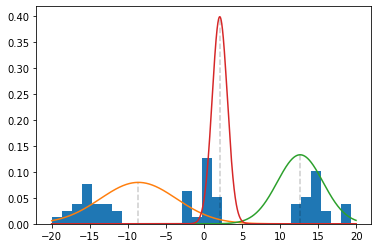

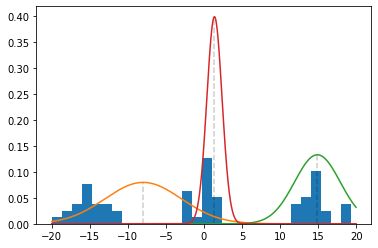

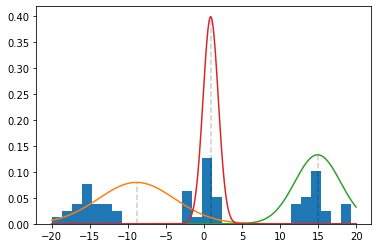

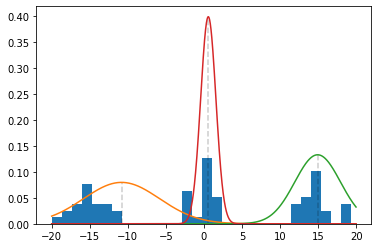

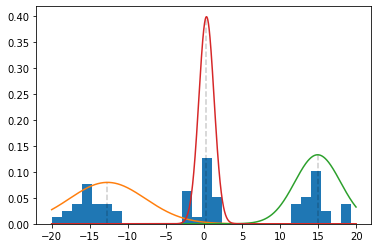

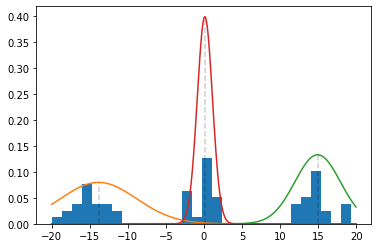

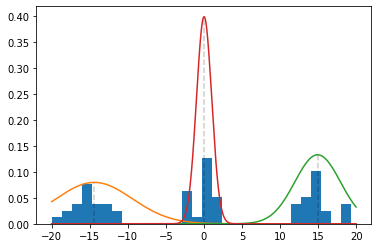

In [56]:
gaussians, mus, sigmas = EM_GMM_1D(X, n_clusters=3, epsilon=0.1)

In [ ]:
#for c,g,p in zip(range(3),["gauss_1","gauss_2","gauss_3"],["pi1","pi2","pi3"]):
#    print(c,g,p)

#for k in range(3):
#    for z in ["gauss_1","gauss_2","gauss_3"]:
#        for p in ["pi1","pi2","pi3"]:
#            print(c,g,p)